## 2. fáza - Predspracovanie

In [421]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb;
import re
import statistics as st
import statsmodels.api as sma
import statsmodels.stats as sms
import statsmodels.stats.api as smsa
from scipy import stats
from sklearn.impute import SimpleImputer

In [2]:
other_train = pd.read_csv("other_train.csv", sep=',', index_col = 0)

In [3]:
other_valid = pd.read_csv("other_valid.csv")

In [4]:
personal_train = pd.read_csv("personal_train.csv",sep=',', index_col = 0)

In [5]:
personal_valid = pd.read_csv("personal_valid.csv")

## Integrácia dát a prípadná deduplikácia záznamov

#### Spojenie datasetov podľa mena
Po spojení datasetov odstránime duplikáty podľa mena, adresy a dodatočne ešte aj veku(v prípade rodiča s dieťatom s rovnakou adresou, vek je faktor čo to rozlíši), pričom však v niektorých riadkoch chýbajú údaje, ktoré ich duplikát má.
Pri deduplikácii bude teda potrebné zlúčiť informácie z duplicitných riadkov do jedného riadku.


In [664]:
finalDataset = pd.merge(other_train,personal_train, on=['name','address'], how='left')
duplicates = finalDataset[finalDataset.duplicated(['name', 'address','age'], keep=False)].sort_values(by = 'name')
finalDataset = finalDataset.drop_duplicates(['name', 'address'], keep=False)
names = duplicates.name.unique()

for name in names:
    tmp = duplicates[duplicates['name'] == name]
    tmp = tmp.fillna(method='ffill')
    tmp = tmp.fillna(method='bfill')
    tmp = tmp.drop_duplicates(['name'])
    finalDataset = finalDataset.append(tmp, ignore_index=True)

#### Úprava dátumov
V dalšej časti si upravéme dútumy na jednotný formát a to spôsobom, že najprv si zistíme aké všetky formáty sa v datasete nachádzajú spôsobom, že všetky čísla v dátume si nahradíme jednotným znakom, v našom prípade nulou.

In [10]:
dateFormats = finalDataset['date_of_birth'].str.replace('[0-9]', '0').value_counts()
dateFormats

0000-00-00             2605
0000-00-00 00:00:00     272
00-00-00                270
00/00/0000              263
0000-00-00 00 00 00     262
0000/00/00              261
Name: date_of_birth, dtype: int64

In [11]:
for format in dateFormats.index:
    dates = np.array(finalDataset[finalDataset['date_of_birth'].str.replace('[0-9]', '0') == format]['date_of_birth'].str.split('[-/ :]').tolist()).astype(np.int)
    print(format)
    print(np.max(dates, axis=0))
    print(np.min(dates, axis=0))

0000-00-00
[2020   12   31]
[1906    1    1]
0000-00-00 00:00:00
[1999   12   31    0    0    0]
[1934    1    1    0    0    0]
00-00-00
[96 12 31]
[5 1 1]
00/00/0000
[  31   12 2010]
[   1    1 1932]
0000-00-00 00 00 00
[2015   12   31    0    0    0]
[1939    1    1    0    0    0]
0000/00/00
[2012   12   31]
[1938    1    1]


Pre všetky formáty si zistíme maximálne hodnoty, aby sme zistili v akom poradi sú dni, mesiace a dni pri formáte 00-00-00 a zároveň môžeme odstránim hodinuovú časť, kedže je vždy nulová.

Môžeme si všimnúť, že najčastejšie používaný formát je klasický YYYY-MM-DD, a na tento formát sa budeme snažiť upraviť aj ostatné, niekedy bude stačiť zmeniť oddelovač inokedy zmazať hodinovú časť a v poslednom prípade zmeniť rok na celé číslo nie len koncovku.

In [353]:
def dateFormat(date):
    dateForm = date.replace('1', '0')
    dateForm = dateForm.replace('2', '0')
    dateForm = dateForm.replace('3', '0')
    dateForm = dateForm.replace('4', '0')
    dateForm = dateForm.replace('5', '0')
    dateForm = dateForm.replace('6', '0')
    dateForm = dateForm.replace('7', '0')
    dateForm = dateForm.replace('8', '0')
    dateForm = dateForm.replace('9', '0')
    return dateForm

In [550]:
def changeDate(date):
    datef = dateFormat(date)
    if(datef == '00-00-00'):
        day = date[6:]
        month = date[:5]
        month = month[3:]
        year = date[:2]
        firstOfYear = year[:1]
        if(firstOfYear == '1' or firstOfYear == '0'):
            year ='20'+year
        else:
            year ='19'+year
        date = year
        date = date+'-'
        date = date+month
        date = date+'-'
        date = date+day
        return date
    if(datef == '0000-00-00 00:00:00'):
        date = date[:10]
        return date
    if(datef == '00/00/0000'):
        day = date[:2]
        month = date[:5]
        month = month[3:]
        year = date[6:]
        date = year
        date = date+'-'
        date = date+month
        date = date+'-'
        date = date+day
        return date
    if(datef == '0000/00/00'):
        date = date.replace('/','-')
        return date
    if(datef == '0000-00-00 00 00 00'):
        date = date[:10]
        return date
    if(datef == '0000-00-00'):
        return date
    else:
        print('no match')
        return date

In [637]:
finalDataset['date_of_birth'] = finalDataset['date_of_birth'].apply(changeDate)

In [552]:
dateFormats = finalDataset['date_of_birth'].str.replace('[0-9]', '0').value_counts()
dateFormats

0000-00-00    3933
Name: date_of_birth, dtype: int64

Po spustení funkcie už máme jednotný formát dátumu.

#### Úprava údaju o tehotenstve
Máme 6 rôznach typov o tehotenstve, 3 pre true a 3 pre false, najviac záznamov používa formát t,f tak ostatné záznamy prevedieme na tento formát zápisu.

In [545]:
finalDataset['pregnant'].value_counts()

f        3459
F         200
FALSE     188
t          81
T           3
TRUE        2
Name: pregnant, dtype: int64

In [546]:
def changePregnantInfoFlag(flag):
    if(flag == 'F'):
        return 'f'
    if(flag == 'FALSE'):
        return 'f'
    if(flag == 'T'):
        return 't'
    if(flag == 'TRUE'):
        flag = 't'
    if(flag == 't'):
        return 't'
    if(flag == 'f'):
        return 'f'

In [665]:
finalDataset['pregnant'] = finalDataset['pregnant'].apply(changePregnantInfoFlag)

In [548]:
finalDataset['pregnant'].value_counts()

f    3847
t      86
Name: pregnant, dtype: int64

Po vykonaní funkcie máme všetko v jednotnom formáte t,f.

#### Odstránenie \r\n z adresy a nahradenie medzerou

In [286]:
finalDataset['address'].head(1)

0    52925 Barton Ville Suite 664\r\nEast Whitney, ...
Name: address, dtype: object

In [348]:
def addressCorrection(address):
    address = address.replace('\r\n',' ')
    return address

In [666]:
finalDataset['address'] = finalDataset['address'].apply(addressCorrection)

In [289]:
finalDataset['address'].head(1)

0    52925 Barton Ville Suite 664 East Whitney, DC ...
Name: address, dtype: object

#### Oprava pohlavia odstráneni medzery spred začiatku slova

In [599]:
def fixSex(sex):
    sex = sex.replace(' ','')
    return sex

In [667]:
finalDataset['sex'] = finalDataset['sex'].apply(fixSex)

#### Otestovanie možných problémov, ktoré nás nenapadli počas prvej fázy projektu.

In [618]:
finalDataset['sex'].value_counts()

 Male      2646
 Female    1287
Name: sex, dtype: int64

In [668]:
test = finalDataset[finalDataset['pregnant'] == 't']
test = test[test['sex'] == 'Male']
test['sex'].count()

16

Máme 16 mužov ktorý sú tehotný upravíme tieto záznamy.

In [669]:
finalDataset.loc[(finalDataset["sex"] == 'Male') & (finalDataset["pregnant"] == 't') , 'pregnant'] = 'f'

In [670]:
test = finalDataset[finalDataset['pregnant'] == 't']
test = test[test['sex'] == 'Male']
test['sex'].count()

0

#### Následne sa pozrieme cez pairplot na číslené atribúty.

In [461]:
finalDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 24 columns):
name                3933 non-null object
address             3933 non-null object
kurtosis_oxygen     3933 non-null float64
pregnant            3931 non-null object
education-num       3933 non-null float64
relationship        3933 non-null object
skewness_glucose    3932 non-null float64
mean_glucose        3539 non-null float64
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3933 non-null float64
kurtosis_glucose    3932 non-null float64
personal_info       3931 non-null object
education           3933 non-null object
fnlwgt              3931 non-null float64
class               3933 non-null float64
std_glucose         3933 non-null float64
income              3931 non-null object
mean_oxygen         3933 non-null float64
hours-per-week      3933 non-null float64
capital-loss        3932 non-null float64
age               

In [291]:
columnsDiabetes = finalDataset[['kurtosis_oxygen','skewness_glucose','mean_glucose','std_oxygen','skewness_oxygen','kurtosis_glucose','std_glucose','mean_oxygen','class']]
columnsOthers = finalDataset[['education-num','capital-gain','fnlwgt','hours-per-week','capital-loss','age','class']]

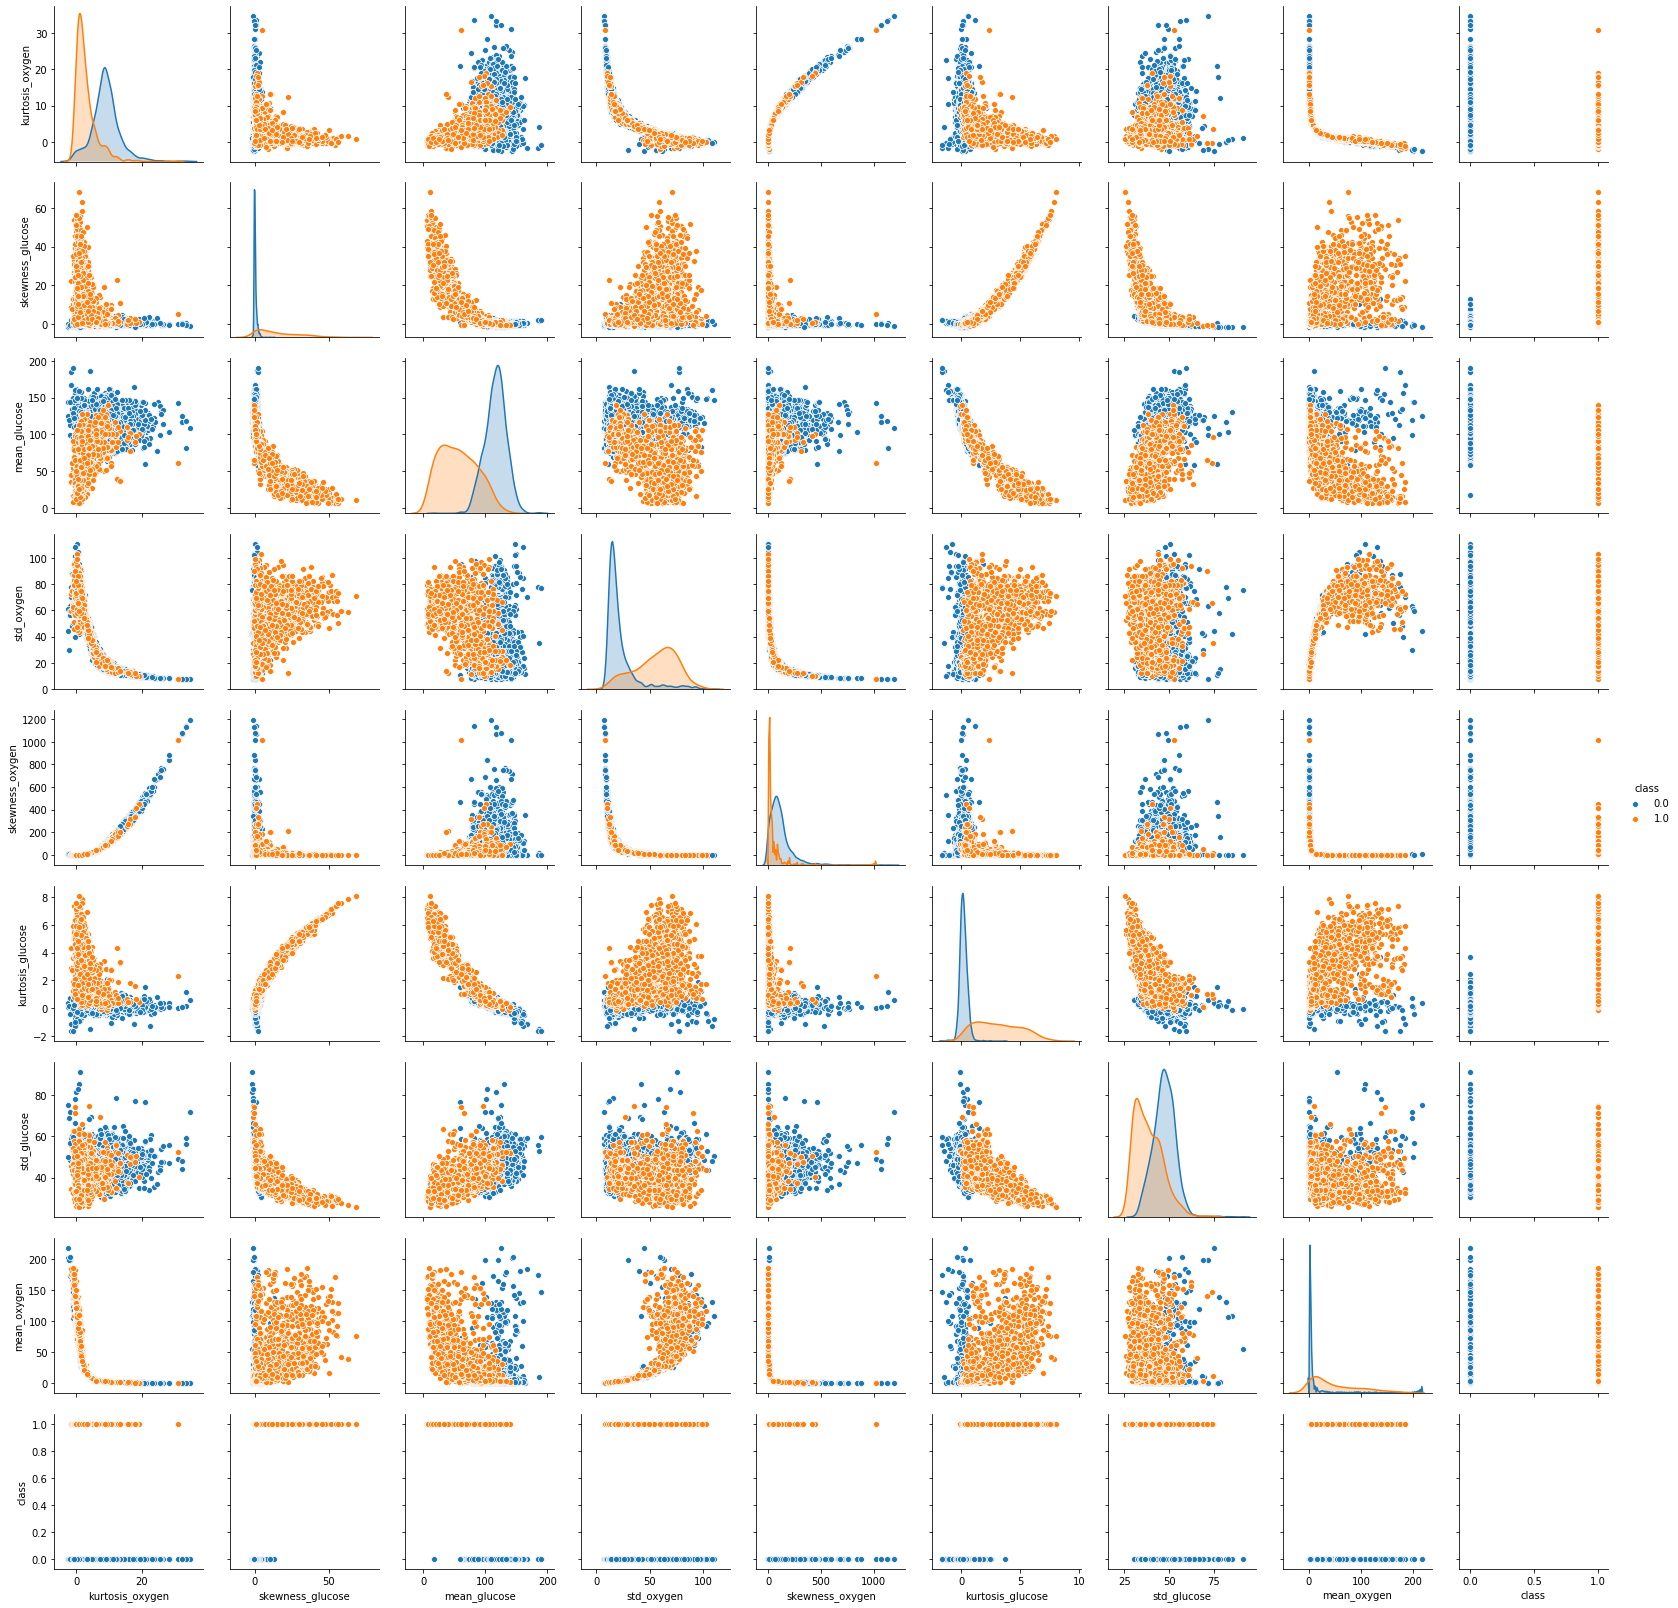

In [294]:
sb.pairplot(columnsDiabetes, hue='class')

Pri niektorých údajoch si môžeme vidieť outlierov, ktorými sa budeme zaoberať neskôr.

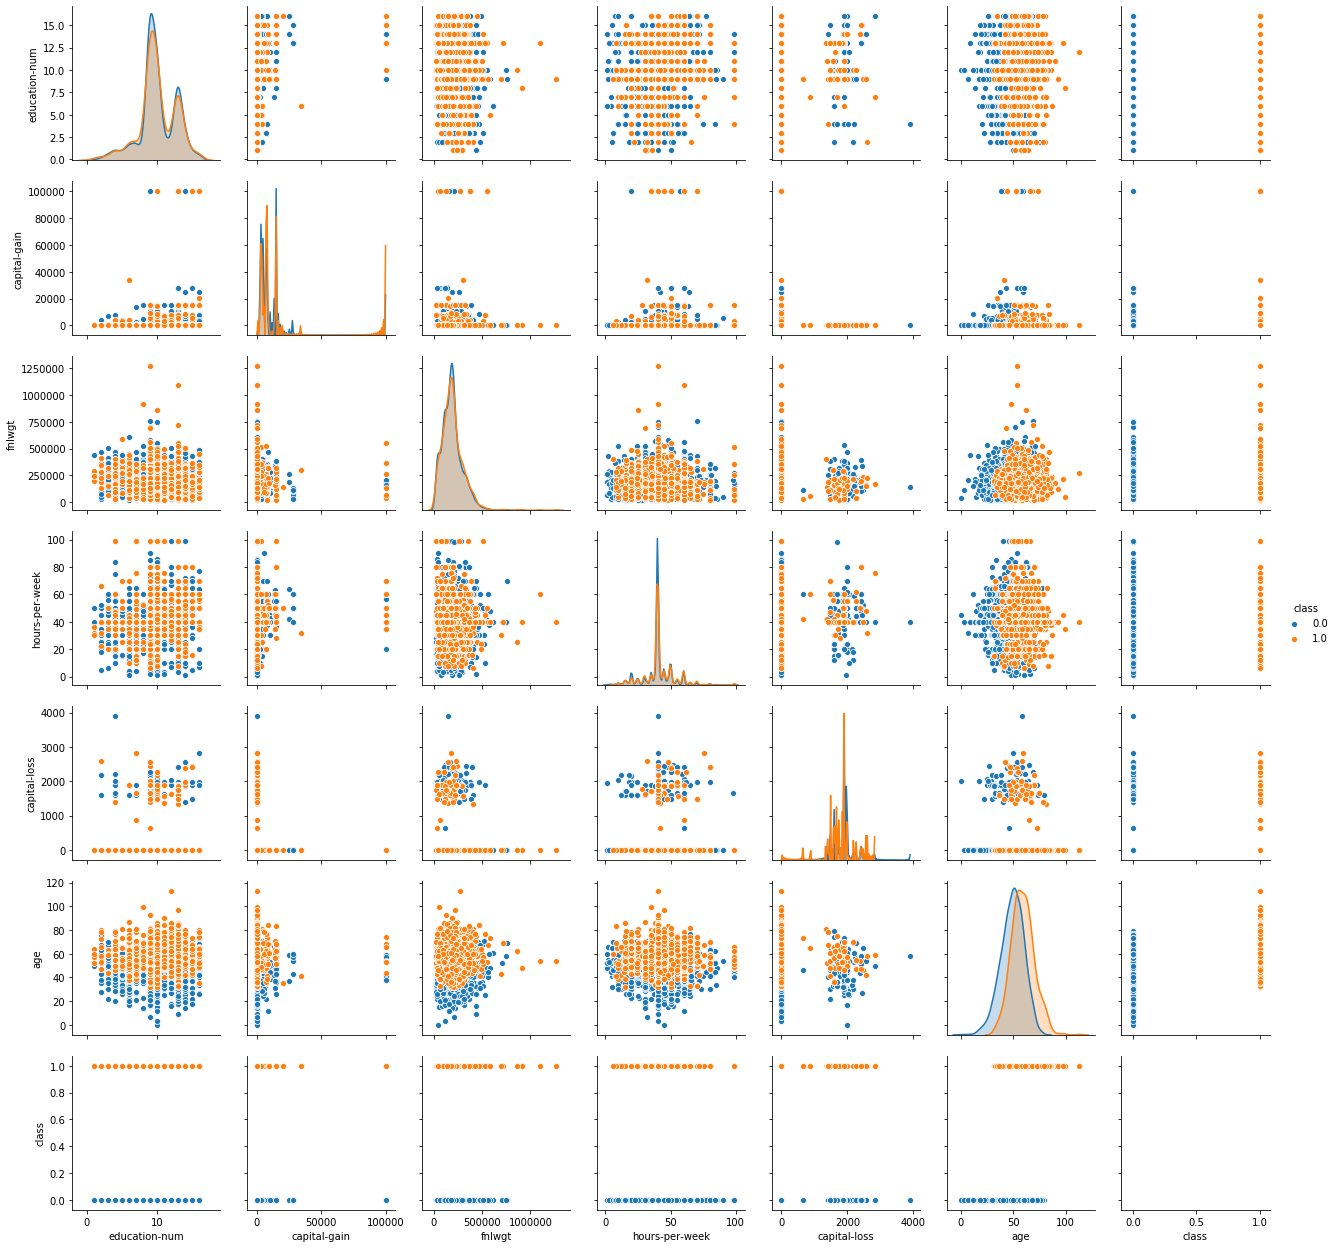

In [293]:
sb.pairplot(columnsOthers, hue='class')

Stĺpce capital-gain a capital-loss môžeme pre zjednodušenie zlúčiť do jedného a to capital tak, že od stĺpca capital-gain odrátame hodnotu pri capital-loss.

In [671]:
finalDataset['capital'] = finalDataset['capital-gain'] - finalDataset['capital-loss']

In [672]:
del finalDataset["capital-gain"]
del finalDataset["capital-loss"]

##  Realizácia krokov predspracovania dát a ich zdokumentovanie


### Riešení chýbajúcich hodnôt

In [673]:
finalDataset.isna().sum()

name                  0
address               0
kurtosis_oxygen       1
pregnant              0
education-num         0
relationship          0
skewness_glucose      1
mean_glucose        394
std_oxygen            0
skewness_oxygen       0
kurtosis_glucose      1
personal_info         2
education             0
fnlwgt                2
class                 0
std_glucose           0
income                2
mean_oxygen           0
hours-per-week        0
age                   0
sex                   0
date_of_birth         0
capital               1
dtype: int64

Po spojení atribútov nemáme veľké množstvo chýbajúcih záznamov, avšak najviac nám chýba pri jednom z najdôležitejších atribútov. Pre číselné atribúty, kde nám chýba do 10 záznamov použijeme strednú hodnotu, v opačnom prípade použijeme .... TODO.
Pre kategorické vytvoríme nový segment 'undefined' ak nebudem schopný logický prísť nato , čo daný záznam má obsahovať.

In [440]:
def setMissingValuesToMean(dataset,column):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_mean = imp_mean.fit(finalDataset[[column]])
    dataset[column] = imp_mean.transform(dataset[[column]]).ravel()

In [657]:
def setMissingValuesToMedian(dataset,column):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
    imp_mean = imp_mean.fit(finalDataset[[column]])
    dataset[column] = imp_mean.transform(dataset[[column]]).ravel()

Segment v našom prípade bude pohlavie

In [630]:
def setMissingValuesToSegmentMean(dataset,column):
    meanMale = finalDataset[finalDataset['sex'] == 'Male'][column].mean()
    meanFemale = finalDataset[finalDataset['sex'] == 'Female'][column].mean()
    dataset.loc[(dataset[column].isnull()) & (dataset['sex'] == 'Male') , column] = meanMale
    dataset.loc[(dataset[column].isnull()) & (dataset['sex'] == 'Female') , column] = meanFemale

In [651]:
def setMissingValueToUndefined(dataset,column):
     dataset.loc[dataset[column].isna(), column] = 'undefined'

### kurtosis_oxygen

In [452]:
k = finalDataset[finalDataset['kurtosis_oxygen'].isna()]
k

,name,address,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,capital-gain,...,fnlwgt,class,std_glucose,income,mean_oxygen,hours-per-week,capital-loss,age,sex,date_of_birth
3890,Carl Crumpler,"136 Bennett Crescent\r\nNorth Jeremy, SD 72004",NaN,f,13.0,Husband,-0.386134,NaN,38.656632,0.0,...,131463.0,0.0,53.360617,<=50K,11.18311,40.0,0.0,47,Male,1972-08-08


Na prvom atribúte si pre istotu spravím kontrolu.

In [453]:
finalDataset['kurtosis_oxygen'][3890]

nan

In [454]:
mean =finalDataset['kurtosis_oxygen'].mean()
mean

7.414483362401841

In [674]:
setMissingValuesToMean(finalDataset,'kurtosis_oxygen')

In [456]:
finalDataset['kurtosis_oxygen'][3890]

7.414483362401831

Všeko vyzerá v poriadku, pre ostatné atribúty budem iba volať funkciu na nastavenie hodnôt.

### skewness_glucose

In [675]:
setMissingValuesToMean(finalDataset,'skewness_glucose')

### mean_glucose
Na tento atribút použijem nahradenie chýbajúcej hodnoty priemerom segmentu

Skewness: -1.0389560856351583


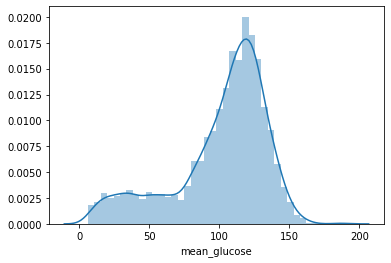

In [645]:
sb.distplot(finalDataset['mean_glucose'], bins=40)
print("Skewness:", finalDataset['mean_glucose'].skew())

In [676]:
setMissingValuesToSegmentMean(finalDataset,'mean_glucose')

Skewness: -1.095297065302652


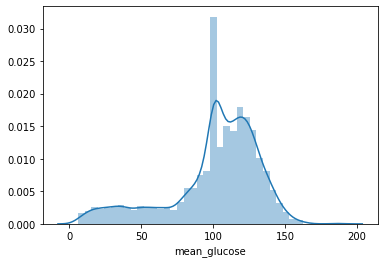

In [635]:
sb.distplot(finalDataset['mean_glucose'], bins=40)
print("Skewness:", finalDataset['mean_glucose'].skew())

Po použití doplnenia chýbajúcich záznamov sa nám skewness trochu zhoršila, ale nie je to vešký rozdiel. Pri ostatných atribútoch grafy nie sp, pretože doplnenie jednej alebo 2 hodnôt by bolo nepostriehnuteľné.

### kurtosis_glucose

In [677]:
setMissingValuesToMean(finalDataset,'kurtosis_glucose')

### personal info
pre daný kategorická atribpt nemá ako získať dané hodnoty, preto nastavíme chýbajpce hodnoty na hodnotu 'undefined'

In [678]:
setMissingValueToUndefined(finalDataset,'personal_info')

### fnlwgt
údaj moc význam nemá ale doplním mu tam hodnotu mediánu

In [680]:
setMissingValuesToMedian(finalDataset,'fnlwgt')

### income a capital
Opätovne nemám ako zistiť príjmy daných osúb, teda chýbajúce hodnoty nastavím na 'undefined'.

In [682]:
setMissingValueToUndefined(finalDataset,'income')

In [684]:
setMissingValueToUndefined(finalDataset,'capital')

In [685]:
finalDataset.isna().sum()

name                0
address             0
kurtosis_oxygen     0
pregnant            0
education-num       0
relationship        0
skewness_glucose    0
mean_glucose        0
std_oxygen          0
skewness_oxygen     0
kurtosis_glucose    0
personal_info       0
education           0
fnlwgt              0
class               0
std_glucose         0
income              0
mean_oxygen         0
hours-per-week      0
age                 0
sex                 0
date_of_birth       0
capital             0
dtype: int64

###  Riešenie vychýlených hodnôt - outlierov

### TODO - popis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E914CD3E10>,
      dtype=object)

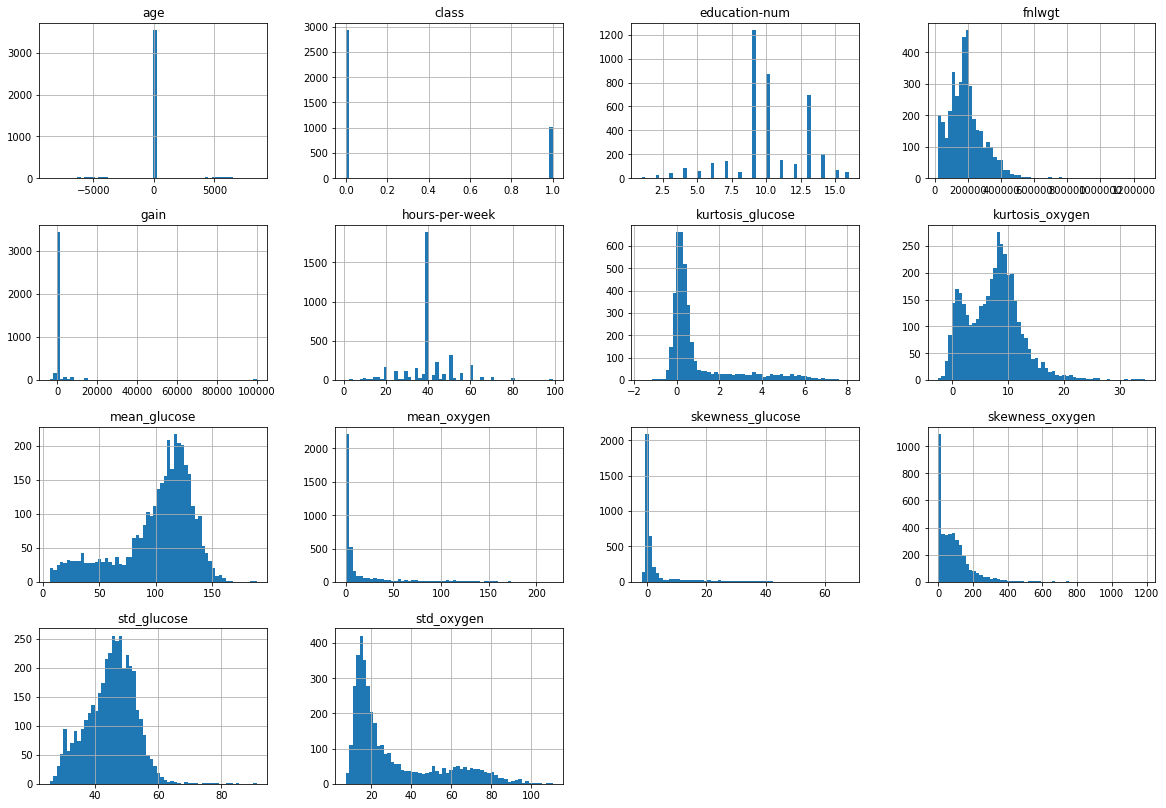

In [366]:
finalDataset.hist(figsize=(20, 14), bins=60)

#### Uprava veku
V datasete sme spozorovali, že neplatný vek bol spôsobený tým, že vek tam bol vynásobený 100 a niekedy v zápornom čísle, čo sme jednoduchou funkciou upravili, takže sme na daný atribút neodstránili outlierov, ani sme ich nerátali iným spôsob, pretože to by nám dáta iba skreslilo.

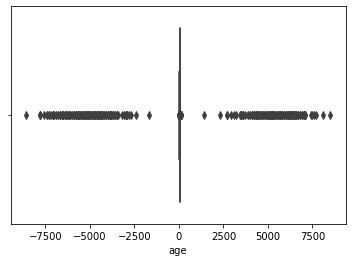

In [338]:
sb.boxplot(personal_train['age'])

Vek pred úpravou

In [335]:
def repair_age(age):
    if pd.isnull(age):
        return pd.Series(np.nan)
    if age >= 130:
        return int(age / 100)
    if age < 0:
        return int(((age * -1) / 100))
    else:
        return int(age)

In [336]:
finalDataset['age'] = finalDataset['age'].apply(repair_age)

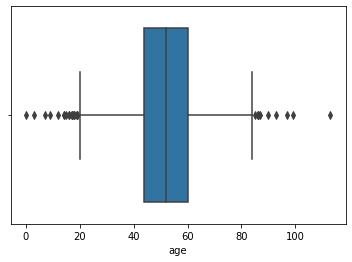

In [337]:
sb.boxplot(finalDataset['age'])

Môžeme vidieť, že v novom datasete po vykonaní funkcie na úpravu veku, sa už nenchádzajú nemožné veky.

Atribúty class, education-num ,neriešime, pretože môžeme vidieť že obsahujú normálne hodnoty už z grafu, hodnotu fnlgwt neriešime, pretože je to nepodstatný parameter, a stlpec gain sme už vyriešili, vyššie, takže jemu sa už tiež venovať nebudeme, aj ked tam je jedna hodnota, ktorú si môžeme všimúť, že je určite outlier, no pre príjem penazí nemôžme povedať, žeby tá hodnota bola nereálna, preto ju nebudeme riešiť.

Poďme sa pozrieť na ostatné, ako prvé odstránime hodnoty nan vypočítame si outleirov a následne ich odstránime, pričom ich neskôr nahradíme zmysluplnejšími údajmi podľa zvolenej metódy. 

In [374]:
hours = finalDataset[(finalDataset['hours-per-week'] < 0) & (finalDataset['hours-per-week'] > 168)]
hours['hours-per-week'].count()

0

Ani jeden záznam pracovního času nie je mimo rozmedzie.

In [436]:
Data = {'field':  ['minV','OutMin','OutMax','95percentil','5percentil','methodNoOut']}
datasetProcessValues = pd.DataFrame(Data,columns=['field','kurtosis_glucose', 'kurtosis_oxygen','mean_glucose','mean_oxygen','skewness_glucose','skewness_oxygen','std_glucose','std_oxygen'])

In [701]:
def getMinFromDataset(dataset,column):
    min = dataset[column].min()
    return float(min)

In [700]:
def method3(dataset,column):
    minimumValue = datasetProcessValues[column][0]
    if minimumValue < 0:
        minimumValueForLogShift = (minimumValue * -1) + 0.5
        dataset[column] = dataset[column] + minimumValueForLogShift
    dataset.dropna(subset=[column], inplace=True)
    dataset[column] = np.log(dataset[column])

In [699]:
def method1(dataset,column,minV,maxV):
    upperQ = datasetProcessValues[column][4]
    dataset[dataset[column] > maxV] = upperQ
    
    lowerQ = datasetProcessValues[column][5]
    dataset[dataset[column] < minV] = lowerQ
    

In [189]:
def outlierCalculationWithValueShift(column,minAdd,maxAdd):
    lowQ,highQ = finalDataset[column].quantile([0.25, 0.75])
    interquartile = highQ-lowQ
    max = highQ + 1.5*(interquartile) + maxAdd
    min = lowQ - 1.5*(interquartile) - minAdd
    print("Boxplot:\n * minimum value: ",min,"\n * maximum value: ",max)
    print('Number of outliers: ', finalDataset[~finalDataset[column].between(min,max)][column].count())
    print("Number of smaller values than min: ", sum(finalDataset[column] < min))
    print("Number of higher values than max: ", sum(finalDataset[column] > max))
    return float(min),float(max)

In [109]:
def outlierCalculation(column):
    lowQ,highQ = finalDataset[column].quantile([0.25, 0.75])
    interquartile = highQ-lowQ
    max = highQ + 1.5*(interquartile)
    min = lowQ - 1.5*(interquartile)
    print("Boxplot:\n * minimum value: ",min,"\n * maximum value: ",max)
    print('Number of outliers: ', finalDataset[~finalDataset[column].between(min,max)][column].count())
    print("Number of smaller values than min: ", sum(finalDataset[column] < min))
    print("Number of higher values than max: ", sum(finalDataset[column] > max))
    sb.boxplot(finalDataset[column]).set_title(column + " BoxPlot")
    plt.show()
    print('Skewness:', finalDataset[column].skew())
    print('Kurtosis:', finalDataset[column].kurtosis())
    sb.distplot(finalDataset[column].dropna()).set_title(column + ' Distplot')
    plt.show()
    tmpDataset = finalDataset[column].dropna()

    #--------------------------------------------------------------
    
    print('\n\nMetóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)')
    
    datasetFirstMethod = tmpDataset
    upperQ = np.percentile(datasetFirstMethod,95)
    datasetFirstMethod[datasetFirstMethod > max] = upperQ

    lowerQ = np.percentile(datasetFirstMethod, 5)
    datasetFirstMethod[datasetFirstMethod < min] = lowerQ
    
    sb.boxplot(datasetFirstMethod)
    plt.show()
    
    print('Skewness: ', datasetFirstMethod.skew())
    print('Kurtosis:', datasetFirstMethod.kurtosis())
    
    sb.distplot(datasetFirstMethod).set_title(column + ' Distplot after method 1')
    plt.show()
    
    #-----------------------------------------------------------------
    
    print('\n\nMetóda 2: Odstránenie odľahlých pozorovaní')
     
    datasetSecondMethod = tmpDataset
    datasetSecondMethod = datasetSecondMethod[(datasetSecondMethod < max) & (datasetSecondMethod > min)]
    sb.boxplot(datasetSecondMethod)
    plt.show()
    
    print('Skewness: ', datasetSecondMethod.skew())
    print('Kurtosis:', datasetSecondMethod.kurtosis())
    
    sb.distplot(datasetSecondMethod).set_title(column + ' Distplot after method 2')
    plt.show()  
    
    #------------------------------------------------------------------
    check = tmpDataset
    if(check[(check < 0)].count() == 0):
    
        print('\n\nMetóda 3: Transformácia atribútu s vychýlenými hodnotami pomocou zvolenej funkcie (logaritmus, odmocnina a pod.')
        datasetThirdMethod = np.log(tmpDataset)
        sb.boxplot(datasetThirdMethod)
        plt.show()
    
        print('Skewness: ', datasetThirdMethod.skew())
        print('Kurtosis:', datasetThirdMethod.kurtosis())
    
        sb.distplot(datasetThirdMethod).set_title(column + ' Distplot after method 3')
        plt.show()

## kurtosis_glucose

Boxplot:
 * minimum value:  -0.9851250870000002 
 * maximum value:  1.8346323090000003
Number of outliers:  703
Number of smaller values than min:  10
Number of higher values than max:  693


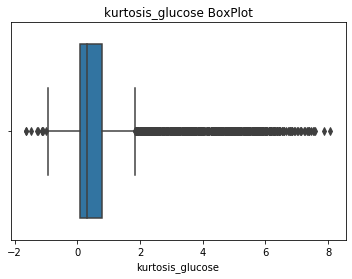

Skewness: 2.039531183396854
Kurtosis: 3.3245684651659717


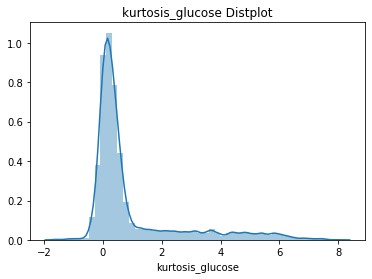



Metóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)


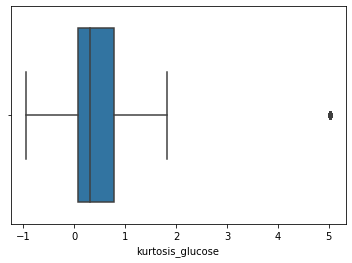

Skewness:  1.5612962106333956
Kurtosis: 0.6364102610321694


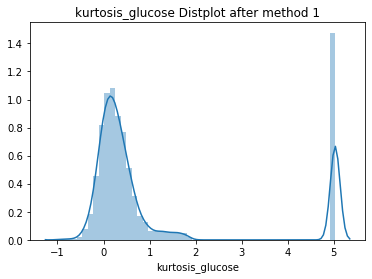



Metóda 2: Odstránenie odľahlých pozorovaní


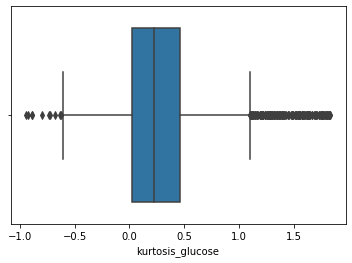

Skewness:  1.2385769222009493
Kurtosis: 2.488046891001913


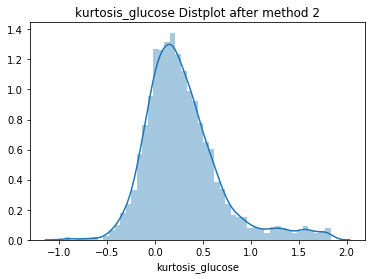

In [320]:
outlierCalculation('kurtosis_glucose')

Nahradenie maximálnej hodnoty pri outlieroch vyššiou hodnotou, pretože výpočet nám povedal že máme 700 outlierov, ale môžeme vidieť, že reálne dané hodnoty nemusia byť outliery. Posunuli sme hodnotu maxu o 6. Následne použijeme metódu 1 na finálnu úpravu. Napriek tomu, že po odstránením hodnôt(metóda 2) sa náš skewness priblížil najviac k nule, t.j rozloženie bolo viac rovnomerné, prišli by sme o dosť meraní, preto na ďalších atribútoch budeme pokračovať iba metódami 1 a 3.

In [231]:
minVKG,maxVKG = outlierCalculationWithValueShift('kurtosis_glucose',0,6)

Boxplot:
 * minimum value:  -0.9851250870000002 
 * maximum value:  7.834632309
Number of outliers:  12
Number of smaller values than min:  10
Number of higher values than max:  2


In [319]:
datasetProcessValues['kurtosis_glucose'][0] = getMinFromDataset(finalDataset,'kurtosis_glucose')
datasetProcessValues['kurtosis_glucose'][1] = minVKG
datasetProcessValues['kurtosis_glucose'][2] = maxVKG
datasetProcessValues['kurtosis_glucose'][4] = np.percentile(finalDataset['kurtosis_glucose'].dropna(),95)
datasetProcessValues['kurtosis_glucose'][5] = np.percentile(finalDataset['kurtosis_glucose'].dropna(),5)
datasetProcessValues['kurtosis_glucose'][6] = 1

In [187]:
method1(finalDataset,'kurtosis_glucose',minVKG,maxVKG)

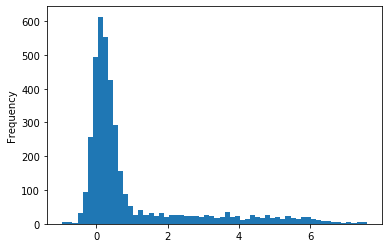

In [123]:
finalDataset['kurtosis_glucose'].plot.hist(bins = 60)

## kurtosis_oxygen

Boxplot:
 * minimum value:  -6.265286084999999 
 * maximum value:  20.180630650999998
Number of outliers:  51
Number of smaller values than min:  0
Number of higher values than max:  51


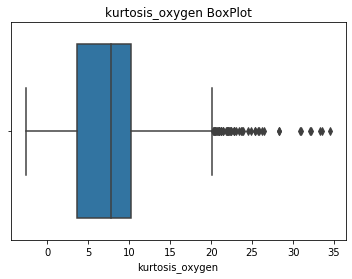

Skewness: 0.6005557112841973
Kurtosis: 1.4082347585688186


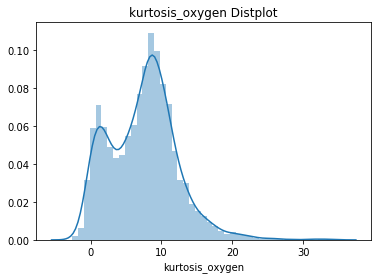



Metóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)


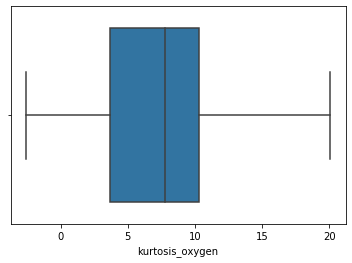

Skewness:  0.09932415649272565
Kurtosis: -0.5299233771155802


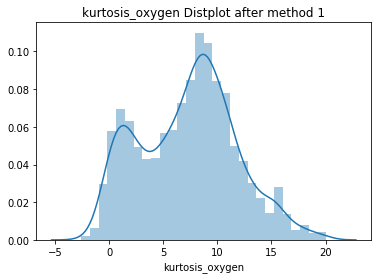



Metóda 2: Odstránenie odľahlých pozorovaní


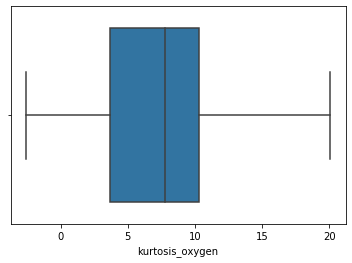

Skewness:  0.09932415649272565
Kurtosis: -0.5299233771155802


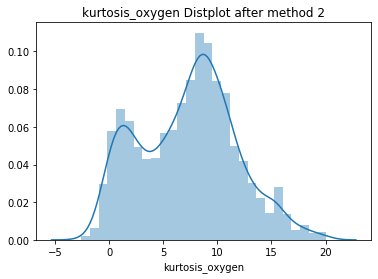

In [322]:
outlierCalculation('kurtosis_oxygen')

Podobne ako pri atribúte kurtosis_glucose, použijeme na úpravu outlierov metódu 1 s tým, že predtým posunieme hranicu maxu pri výpočte outlierov z 20 na 28.

In [233]:
minVKO,maxVKO = outlierCalculationWithValueShift('kurtosis_oxygen',0,8)

Boxplot:
 * minimum value:  -6.265286084999999 
 * maximum value:  28.180630650999998
Number of outliers:  9
Number of smaller values than min:  0
Number of higher values than max:  9


In [327]:
test = finalDataset[finalDataset['kurtosis_oxygen'] < -3]
test

,name,address,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,capital-gain,...,fnlwgt,class,std_glucose,income,mean_oxygen,hours-per-week,capital-loss,age,sex,date_of_birth


In [323]:
datasetProcessValues['kurtosis_oxygen'][0] = getMinFromDataset(finalDataset,'kurtosis_oxygen')
datasetProcessValues['kurtosis_oxygen'][1] = minVKO
datasetProcessValues['kurtosis_oxygen'][2] = maxVKO
datasetProcessValues['kurtosis_oxygen'][4] = np.percentile(finalDataset['kurtosis_oxygen'].dropna(),95)
datasetProcessValues['kurtosis_oxygen'][5] = np.percentile(finalDataset['kurtosis_oxygen'].dropna(),5)
datasetProcessValues['kurtosis_oxygen'][6] = 1

In [210]:
method1(finalDataset,'kurtosis_oxygen',minVKO,maxVKO)

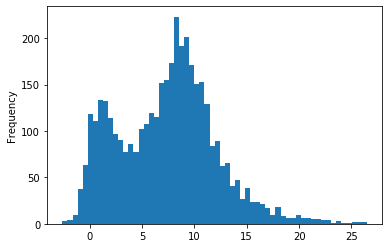

In [211]:
finalDataset['kurtosis_oxygen'].plot.hist(bins = 60)

## mean_glucose

Boxplot:
 * minimum value:  32.474609375 
 * maximum value:  179.302734375
Number of outliers:  236
Number of smaller values than min:  233
Number of higher values than max:  3


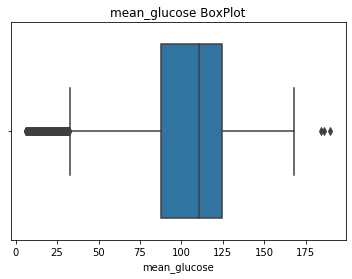

Skewness: -1.0389560856351583
Kurtosis: 0.42179633995163


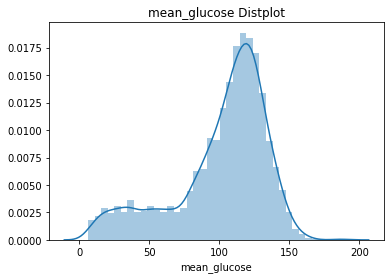



Metóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)


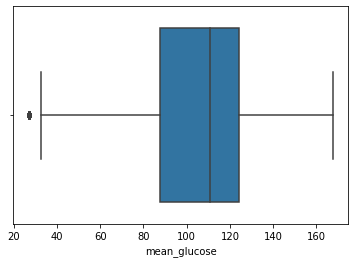

Skewness:  -0.9505122431519525
Kurtosis: 0.08293302188140039


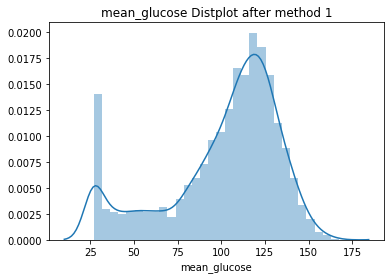



Metóda 2: Odstránenie odľahlých pozorovaní


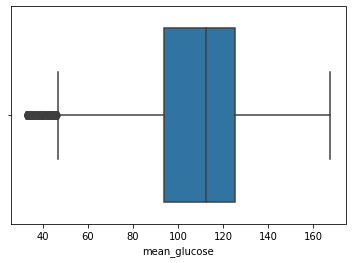

Skewness:  -0.8871733646778618
Kurtosis: 0.3950936934644522


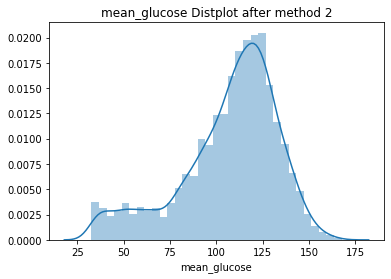



Metóda 3: Transformácia atribútu s vychýlenými hodnotami pomocou zvolenej funkcie (logaritmus, odmocnina a pod.


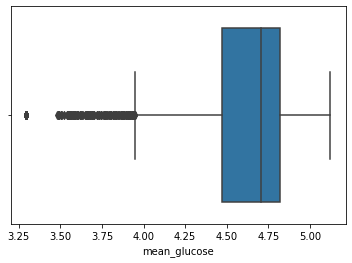

Skewness:  -1.678987368879409
Kurtosis: 1.9010408516731117


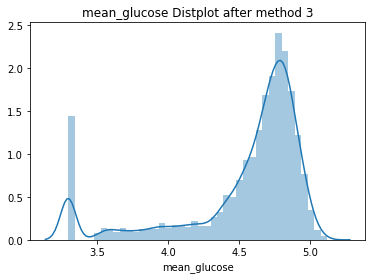

In [494]:
outlierCalculation('mean_glucose')

In [213]:
minVMG,maxVMG = outlierCalculationWithValueShift('mean_glucose',25,0)

Boxplot:
 * minimum value:  6.9794921875 
 * maximum value:  179.5185546875
Number of outliers:  8
Number of smaller values than min:  5
Number of higher values than max:  3


In [317]:
datasetProcessValues['mean_glucose'][0] = getMinFromDataset(finalDataset,'mean_glucose')
datasetProcessValues['mean_glucose'][1] = minVMG
datasetProcessValues['mean_glucose'][2] = maxVMG
datasetProcessValues['mean_glucose'][4] = np.percentile(finalDataset['mean_glucose'].dropna(),95)
datasetProcessValues['mean_glucose'][5] = np.percentile(finalDataset['mean_glucose'].dropna(),5)
datasetProcessValues['mean_glucose'][6] = 1

In [251]:
method3(finalDataset,'mean_glucose')

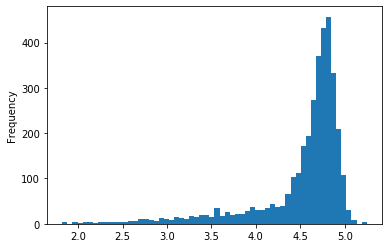

In [252]:
finalDataset['mean_glucose'].plot.hist(bins = 60)

In [197]:
outlierCalculationWithValueShift('mean_glucose',0,0)

Boxplot:
 * minimum value:  3.9286345860141028 
 * maximum value:  5.356630059652301
Number of outliers:  435
Number of smaller values than min:  435
Number of higher values than max:  0


(3.9286345860141028, 5.356630059652301)

Ako vidím logaritmovanie mi nebolohlo k zníženiu počtu outlierov, a rolzoženie dát vyzerá ešte menej symetrické preto sa vrátim k metóde 1.

In [256]:
method1(finalDataset,'mean_glucose',minVMG,maxVMG)

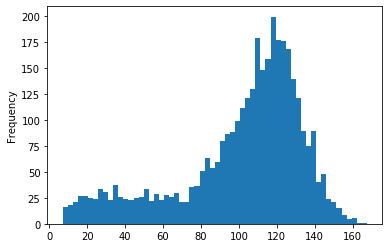

In [257]:
finalDataset['mean_glucose'].plot.hist(bins = 60)

## mean_oxygen

Boxplot:
 * minimum value:  -13.783862872499999 
 * maximum value:  28.4803511635
Number of outliers:  696
Number of smaller values than min:  0
Number of higher values than max:  696


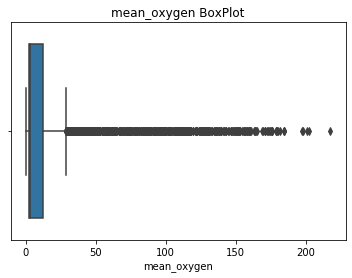

Skewness: 2.625286605478956
Kurtosis: 6.541540376958288


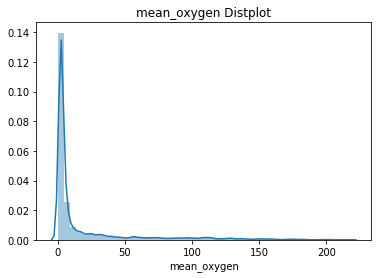



Metóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)


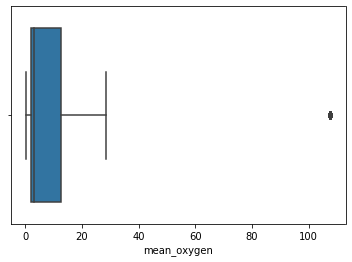

Skewness:  1.6397426813288398
Kurtosis: 0.76508455915907


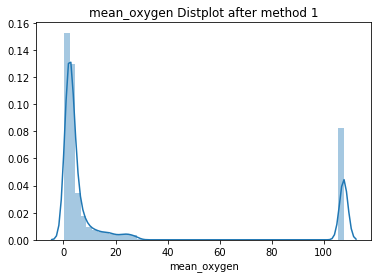



Metóda 2: Odstránenie odľahlých pozorovaní


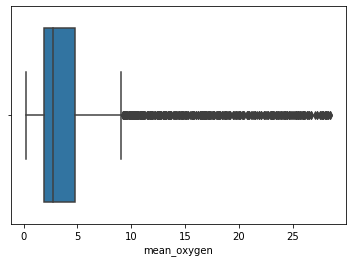

Skewness:  2.503051050063677
Kurtosis: 6.007310301082091


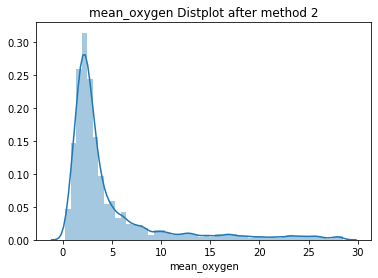



Metóda 3: Transformácia atribútu s vychýlenými hodnotami pomocou zvolenej funkcie (logaritmus, odmocnina a pod.


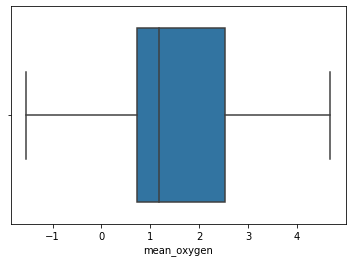

Skewness:  0.9172923267341347
Kurtosis: -0.42197092508470835


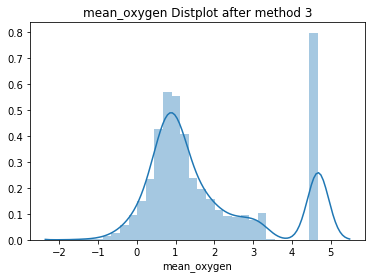

In [228]:
outlierCalculation('mean_oxygen')

Opätovne môžeme vidieť mnočstvo outlierov, ale keď sa nato pozrieme lepšie vidíme, že sú rozmiestnení vcelku pravidelne, nie je to len jeden zhluk mimo ostatných, preto presuniem hranicu až o 150 pre maximálnu.

In [219]:
minVMO,maxVMO = outlierCalculationWithValueShift('mean_oxygen',0,150)

Boxplot:
 * minimum value:  -14.3311036725 
 * maximum value:  179.4147157075
Number of outliers:  10
Number of smaller values than min:  0
Number of higher values than max:  10


In [316]:
datasetProcessValues['mean_oxygen'][0] = getMinFromDataset(finalDataset,'mean_oxygen')
datasetProcessValues['mean_oxygen'][1] = minVMO
datasetProcessValues['mean_oxygen'][2] = maxVMO
datasetProcessValues['mean_oxygen'][4] = np.percentile(finalDataset['mean_oxygen'].dropna(),95)
datasetProcessValues['mean_oxygen'][5] = np.percentile(finalDataset['mean_oxygen'].dropna(),5)
datasetProcessValues['mean_oxygen'][6] = 3

In [221]:
method3(finalDataset,'mean_oxygen')

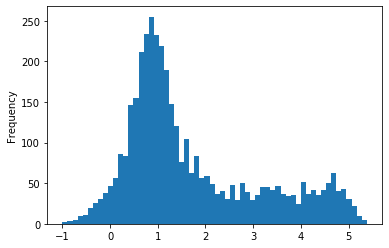

In [222]:
finalDataset['mean_oxygen'].plot.hist(bins = 60)

Pri použití logaritmovania vyzerajú dáta viac symetrické, čiže pre tento atribút použijem danú metódu.

## skewness_glucose

Boxplot:
 * minimum value:  -3.4244922312500004 
 * maximum value:  5.388816532750001
Number of outliers:  678
Number of smaller values than min:  0
Number of higher values than max:  678


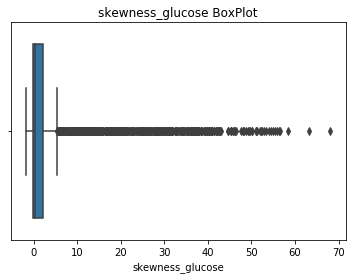

Skewness: 2.8751657622824687
Kurtosis: 8.235978555048101


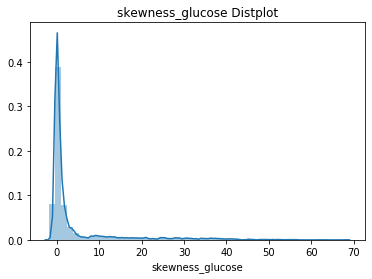



Metóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)


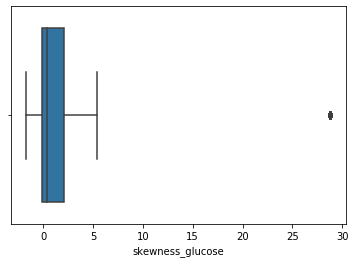

Skewness:  1.7015509275219012
Kurtosis: 0.9484619456547434


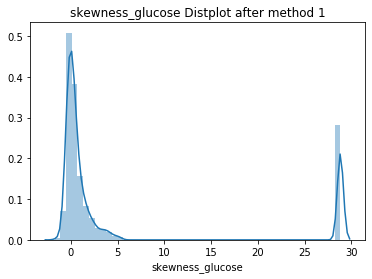



Metóda 2: Odstránenie odľahlých pozorovaní


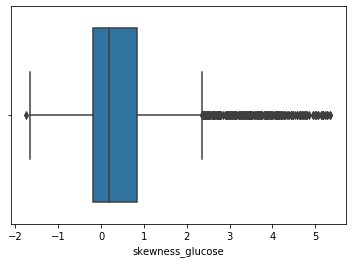

Skewness:  1.799379271714643
Kurtosis: 3.4535056469142744


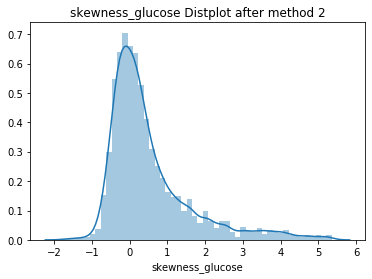

In [495]:
outlierCalculation('skewness_glucose')

Daný atribút má množstvo outlierov, keďže rozdiel medzi horným quartilom a niektorými je príliš veľký skúsim najprv priamo nastaviť outlierov podľa percentilu 5/95 s tým, že hornú hranicu posuniem iba o 10.

In [275]:
minVSG,maxVSG = outlierCalculationWithValueShift('skewness_glucose',0,10)

Boxplot:
 * minimum value:  -3.4244922312500004 
 * maximum value:  15.38881653275
Number of outliers:  406
Number of smaller values than min:  0
Number of higher values than max:  406


In [315]:
datasetProcessValues['skewness_glucose'][0] = getMinFromDataset(finalDataset,'skewness_glucose')
datasetProcessValues['skewness_glucose'][1] = minVSG
datasetProcessValues['skewness_glucose'][2] = maxVSG
datasetProcessValues['skewness_glucose'][4] = np.percentile(finalDataset['skewness_glucose'].dropna(),95)
datasetProcessValues['skewness_glucose'][5] = np.percentile(finalDataset['skewness_glucose'].dropna(),5)
datasetProcessValues['skewness_glucose'][6] = 3

In [277]:
method1(finalDataset,'skewness_glucose',minVSG,maxVSG)

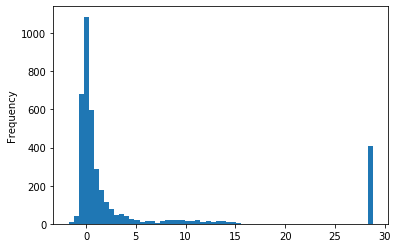

In [278]:
finalDataset['skewness_glucose'].plot.hist(bins = 60)

Toto mi nepríde ako dobrý výsledok a hranicu nechem viac posúvať, preto skúsim najprv použiť metódu 3-logaritmovanie.

In [270]:
method3(finalDataset,'skewness_glucose')

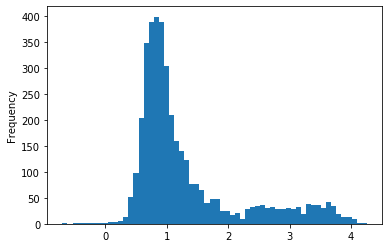

In [271]:
finalDataset['skewness_glucose'].plot.hist(bins = 60)

## skewness_oxygen

Boxplot:
 * minimum value:  -158.351309725 
 * maximum value:  298.22999319499996
Number of outliers:  163
Number of smaller values than min:  0
Number of higher values than max:  163


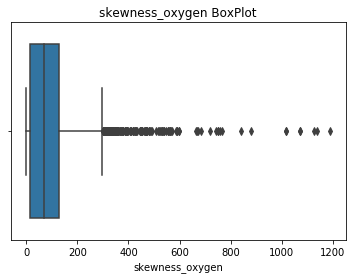

Skewness: 3.1837203295674725
Kurtosis: 18.410318740374397


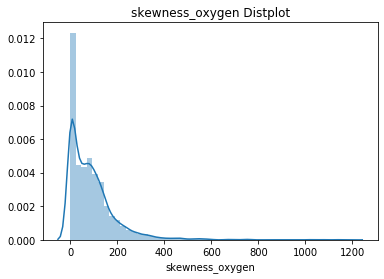



Metóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)


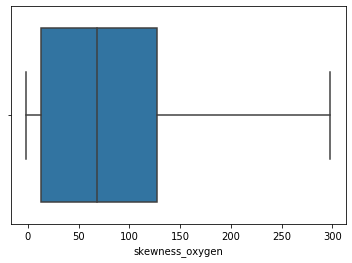

Skewness:  0.9460544073175468
Kurtosis: 0.09554459927754211


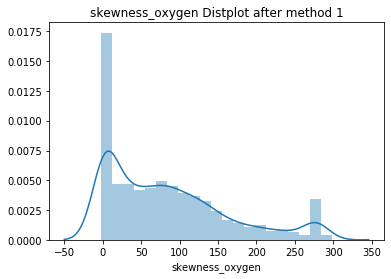



Metóda 2: Odstránenie odľahlých pozorovaní


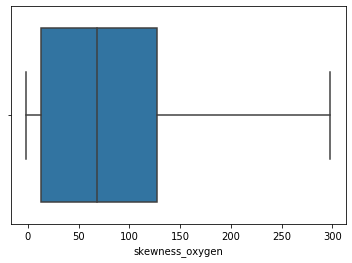

Skewness:  0.9460544073175468
Kurtosis: 0.09554459927754211


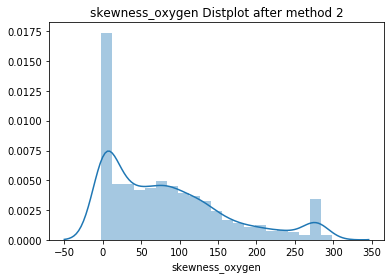

In [499]:
outlierCalculation('skewness_oxygen')

Daný atribút má outlierov vcelku rohádzaných, skúsim najprv použiť metódu logaritmovania.

In [285]:
minVSO,maxVSO = outlierCalculationWithValueShift('skewness_oxygen',0,0)

Boxplot:
 * minimum value:  -158.351309725 
 * maximum value:  298.22999319499996
Number of outliers:  163
Number of smaller values than min:  0
Number of higher values than max:  163


In [314]:
datasetProcessValues['skewness_oxygen'][0] = getMinFromDataset(finalDataset,'skewness_oxygen')
datasetProcessValues['skewness_oxygen'][1] = minVSO
datasetProcessValues['skewness_oxygen'][2] = maxVSO
datasetProcessValues['skewness_oxygen'][4] = np.percentile(finalDataset['skewness_oxygen'].dropna(),95)
datasetProcessValues['skewness_oxygen'][5] = np.percentile(finalDataset['skewness_oxygen'].dropna(),5)
datasetProcessValues['skewness_oxygen'][6] = 3

In [287]:
method3(finalDataset,'skewness_oxygen')

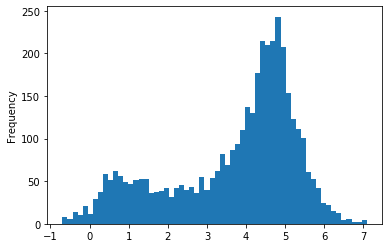

In [289]:
finalDataset['skewness_oxygen'].plot.hist(bins = 60)

## std_glucose

Boxplot:
 * minimum value:  24.860714829999992 
 * maximum value:  65.67407923
Number of outliers:  20
Number of smaller values than min:  0
Number of higher values than max:  20


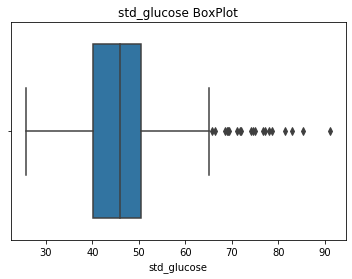

Skewness: 0.027756941125541675
Kurtosis: 0.8036567973355315


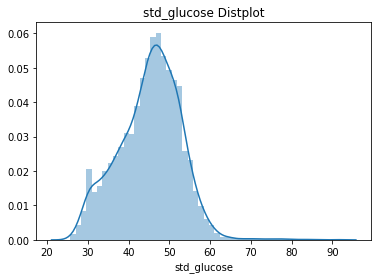



Metóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)


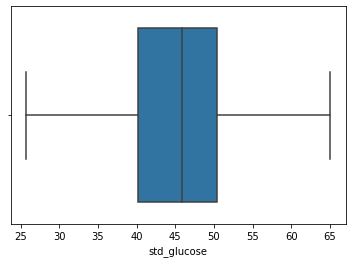

Skewness:  -0.3039688700157517
Kurtosis: -0.4109932332959456


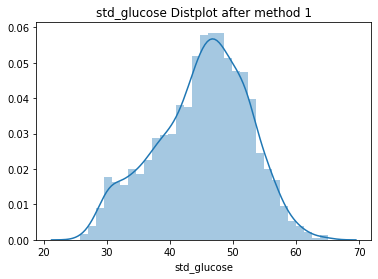



Metóda 2: Odstránenie odľahlých pozorovaní


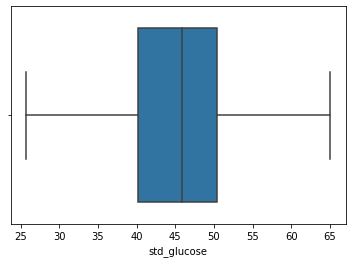

Skewness:  -0.3039688700157517
Kurtosis: -0.4109932332959456


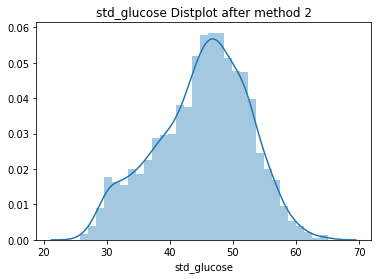



Metóda 3: Transformácia atribútu s vychýlenými hodnotami pomocou zvolenej funkcie (logaritmus, odmocnina a pod.


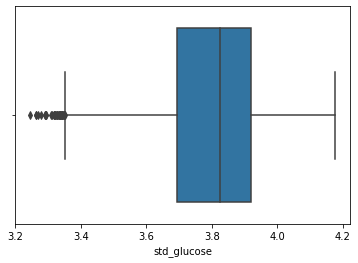

Skewness:  -0.6850830365355961
Kurtosis: -0.035201568402996486


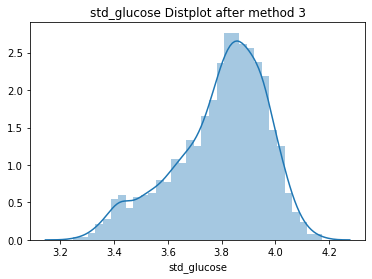

In [496]:
outlierCalculation('std_glucose')

Daný atribút nemá množstvo outlierov, a keď sa nato pozriem hodnoty nevyzerajú byť až tak vzdialené od prípustných, preto iba posuniem hranicu maximálnej prípustnej hodnoty asi na 80 a na zvyšný počet outlierov použijem metódu 1.

In [291]:
minVSTG,maxVSTG = outlierCalculationWithValueShift('std_glucose',0,15)

Boxplot:
 * minimum value:  24.860714829999992 
 * maximum value:  80.67407923
Number of outliers:  4
Number of smaller values than min:  0
Number of higher values than max:  4


In [313]:
datasetProcessValues['std_glucose'][0] = getMinFromDataset(finalDataset,'std_glucose')
datasetProcessValues['std_glucose'][1] = minVSTG
datasetProcessValues['std_glucose'][2] = maxVSTG
datasetProcessValues['std_glucose'][4] = np.percentile(finalDataset['std_glucose'].dropna(),95)
datasetProcessValues['std_glucose'][5] = np.percentile(finalDataset['std_glucose'].dropna(),5)
datasetProcessValues['std_glucose'][6] = 1

In [294]:
method1(finalDataset,'std_glucose',minVSTG,maxVSTG)

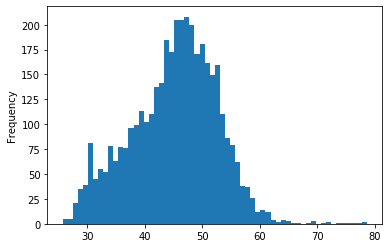

In [295]:
finalDataset['std_glucose'].plot.hist(bins = 60)

## std_oxygen

Boxplot:
 * minimum value:  -27.230313685000002 
 * maximum value:  85.492348115
Number of outliers:  81
Number of smaller values than min:  0
Number of higher values than max:  81


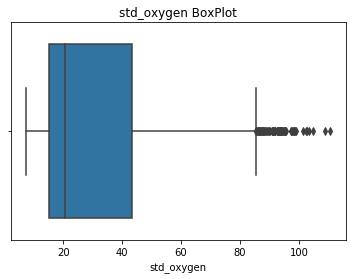

Skewness: 1.2013609024984617
Kurtosis: 0.22590521544548903


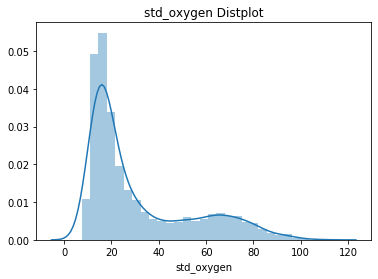



Metóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)


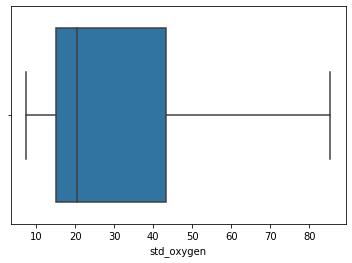

Skewness:  1.0979629283252954
Kurtosis: -0.20073858111137133


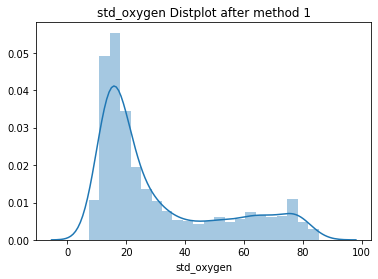



Metóda 2: Odstránenie odľahlých pozorovaní


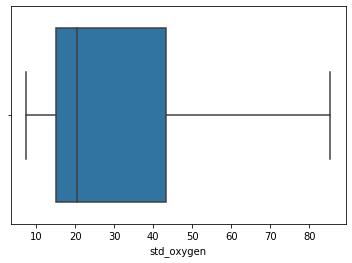

Skewness:  1.0979629283252954
Kurtosis: -0.20073858111137133


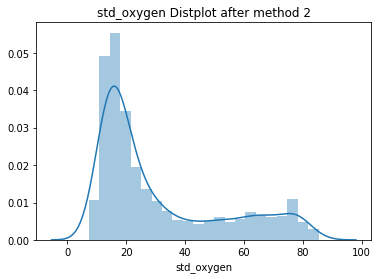



Metóda 3: Transformácia atribútu s vychýlenými hodnotami pomocou zvolenej funkcie (logaritmus, odmocnina a pod.


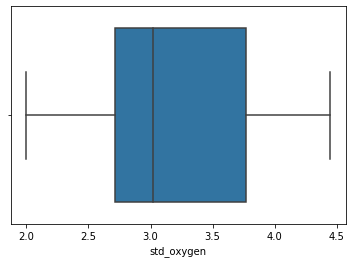

Skewness:  0.516954969192208
Kurtosis: -1.0221805811625346


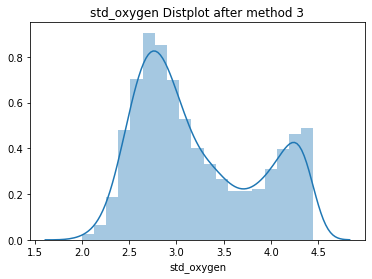

In [497]:
outlierCalculation('std_oxygen')

Podobne ako pri std_glucose, použijem metódu 1, aj keď je počet outleurov o čosi vyšší, stále to vyzerá na prípustné hodnoty. Maximálnu hranicu posuniem asi na hodnotu 100.

In [302]:
minVSTO,maxVSTO= outlierCalculationWithValueShift('std_oxygen',0,15)

Boxplot:
 * minimum value:  -27.278698630000004 
 * maximum value:  100.57298969000001
Number of outliers:  7
Number of smaller values than min:  0
Number of higher values than max:  7


In [312]:
datasetProcessValues['std_oxygen'][0] = getMinFromDataset(finalDataset,'std_oxygen')
datasetProcessValues['std_oxygen'][1] = minVSTO
datasetProcessValues['std_oxygen'][2] = maxVSTO
datasetProcessValues['std_oxygen'][4] = np.percentile(finalDataset['std_oxygen'].dropna(),95)
datasetProcessValues['std_oxygen'][5] = np.percentile(finalDataset['std_oxygen'].dropna(),5)
datasetProcessValues['std_oxygen'][6] = 1

In [306]:
method1(finalDataset,'std_oxygen',minVSTO,maxVSTO)

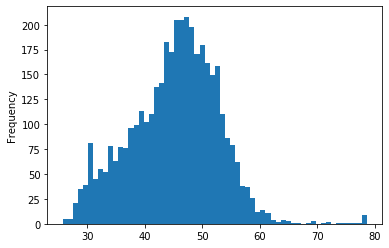

In [307]:
finalDataset['std_glucose'].plot.hist(bins = 60)

# Znovupoužiteľnosť

In [692]:
def mergeDatasets(dataset1,dataset2):
    mergedDataset = pd.merge(dataset1,dataset2, on=['name','address'], how='left')
    duplicates = mergedDataset[mergedDataset.duplicated(['name', 'address','age'], keep=False)].sort_values(by = 'name')
    mergedDataset = mergedDataset.drop_duplicates(['name', 'address'], keep=False)
    names = duplicates.name.unique()

    for name in names:
        tmp = duplicates[duplicates['name'] == name]
        tmp = tmp.fillna(method='ffill')
        tmp = tmp.fillna(method='bfill')
        tmp = tmp.drop_duplicates(['name'])
        mergedDataset = mergedDataset.append(tmp, ignore_index=True)
    return mergedDataset

In [693]:
mergedDataset = mergeDatasets(other_valid,personal_valid)

In [698]:
def dataFixing(dataset):
    dataset['date_of_birth'] = dataset['date_of_birth'].apply(changeDate)
    dataset['pregnant'] = dataset['pregnant'].apply(changePregnantInfoFlag)
    dataset['address'] = dataset['address'].apply(addressCorrection)
    dataset['sex'] = dataset['sex'].apply(fixSex)
    dataset.loc[(dataset["sex"] == 'Male') & (dataset["pregnant"] == 't') , 'pregnant'] = 'f'
    dataset['capital'] = dataset['capital-gain'] - dataset['capital-loss']
    dataset['age'] = dataset['age'].apply(repair_age)
    del dataset["capital-gain"]
    del dataset["capital-loss"]

In [697]:
def missingDataProcessing(dataset):
    setMissingValuesToMean(dataset,'kurtosis_oxygen')
    setMissingValuesToMean(dataset,'skewness_glucose')
    setMissingValuesToSegmentMean(dataset,'mean_glucose')
    setMissingValuesToMean(dataset,'kurtosis_glucose')
    setMissingValueToUndefined(dataset,'personal_info')
    setMissingValuesToMedian(dataset,'fnlwgt')
    setMissingValueToUndefined(dataset,'income')
    setMissingValueToUndefined(dataset,'capital')

In [ ]:
def outlierProcessing(dataset):
    method1(dataset,'kurtosis_glucose',datasetProcessValues['kurtosis_glucose'][1],datasetProcessValues['kurtosis_glucose'][2])
    method1(dataset,'kurtosis_oxygen',datasetProcessValues['kurtosis_oxygen'][1],datasetProcessValues['kurtosis_oxygen'][2])
    method1(dataset,'mean_glucose',datasetProcessValues['mean_glucose'][1],datasetProcessValues['mean_glucose'][2])    
    method3(dataset,'mean_oxygen')
    method3(dataset,'skewness_glucose')
    method3(dataset,'skewness_oxygen')
    method1(dataset,'std_glucose',datasetProcessValues['std_glucose'][1],datasetProcessValues['std_glucose'][2])
    method1(dataset,'std_oxygen',datasetProcessValues['std_oxygen'][1],datasetProcessValues['std_oxygen'][2])

In [ ]:
def finalFunction(dataset1,dataset2):
    mergedDataset = mergeDatasets(dataset1,dataset2)
    dataFixing(mergedDataset)
    missingDataProcessing(merge)